<a href="https://colab.research.google.com/github/lamtung1997/Solving_PDEs_Deep_learning/blob/main/4_Heat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# SETUP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time
import math
import itertools
import os
import logging
from numpy import loadtxt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import cv2
import glob
import imageio

# number pi
pi = math.pi

# random_seed
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
# DATA

dt = 0.2                    # time-step
T = 2                       # T
nots = int(T/dt) + 1        # number of time steps
n = 20                      # number of points in a border
c = np.linspace(0, 1, n)    # coordinates from 0 to 1 with uniform distribution
P_in, P_border = [], []
for i, j, k in itertools.product(range(n), range(n), range(nots)):
    p = [c[i], c[j], k*dt]
    if(i == 0 or i == n-1 or j == 0 or j == n-1):
        P_border.append(p)
    else:
        P_in.append(p)

# upsampling P_border that its size is equal to P_in
for i in range(len(P_in)-len(P_border)):
    j = i%(len(P_border))
    P_border.append(P_border[j])

# convert numpy array, P_in and P_border to Tensorflow Dataset
P_in = tf.convert_to_tensor(P_in, dtype=tf.float32)
P_border = tf.convert_to_tensor(P_border, dtype=tf.float32)

batch_size = 1
bs = int(len(P_in))

P_in = tf.data.Dataset.from_tensor_slices((P_in))
P_in = P_in.shuffle(buffer_size=bs).batch(batch_size).prefetch(4).cache()

P_border = tf.data.Dataset.from_tensor_slices((P_border))
P_border = P_border.shuffle(buffer_size=bs).batch(batch_size).prefetch(4).cache()

print("Number of datas: ", int(P_in.cardinality()*batch_size*2))

Number of datas:  7128


In [3]:
# MODEL
nn = 32
inputs = keras.Input(shape=(3,), name='points')
hidden_1 = layers.Dense(nn, activation='tanh', name='hidden_1')(inputs)
hidden_2 = layers.Dense(nn, activation='tanh', name='hidden_2')(hidden_1)
hidden_3 = layers.Dense(nn, activation='tanh', name='hidden_3')(hidden_2)
hidden_4 = layers.Dense(nn, activation='tanh', name='hidden_4')(hidden_3)
outputs = layers.Dense(1, activation='linear', name="u")(hidden_4)
model = keras.Model(inputs=inputs, outputs=outputs, name='heat_continuous')
model.summary()

Model: "heat_continuous"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
points (InputLayer)          [(None, 3)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 32)                128       
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
hidden_4 (Dense)             (None, 32)                1056      
_________________________________________________________________
u (Dense)                    (None, 1)                 33        
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________

In [4]:
# CHOOSE OPTIMIZER
optimizer = tf.keras.optimizers.Adam()

In [5]:
# TRAIN FUNCTION
@tf.function
def train_step(P_in, P_border):
    with tf.GradientTape(persistent=True) as tape:
        loss_in, loss_border = [0], [0]
        # interior loss
        for i in range(P_in.shape[0]):
            z = tf.reshape(P_in[i], shape=(1,3))
            with tf.GradientTape(persistent=True) as tape1:
                tape1.watch(z)
                with tf.GradientTape(persistent=True) as tape2:  
                    tape2.watch(z)
                    u = model(z)

                # calculating u'
                u_x = tape2.gradient(u, z)[0][0]
                u_y = tape2.gradient(u, z)[0][1]
                u_t = tape2.gradient(u, z)[0][2]
            # u"
            u_xx = tape1.gradient(u_x, z)[0][0]
            u_yy = tape1.gradient(u_y, z)[0][1]

            # calculating f(x,y)
            f = (1 + 2*pi*pi)* tf.math.exp(z[0][2]) * tf.math.sin(pi*z[0][0]) * tf.math.sin(pi*z[0][1])

            # calculating loss_in
            loss_in += tf.math.square(u_t - (u_xx + u_yy) - f)

        # boundary loss
        for j in range(P_border.shape[0]):
            z = tf.reshape(P_border[j], shape=(1,3))
            u = model(z)

            loss_border += tf.math.square(u)
        
        # loss function
        batch_loss = loss_in + loss_border
    
    # update weights
    grads = tape.gradient(batch_loss, model.trainable_weights)          # gradient of loss function with respect to w
    optimizer.apply_gradients(zip(grads, model.trainable_weights))      # update w

    return batch_loss

In [6]:
# TRAIN FUNCTION
losses = []
def train(learning_rate):
    optimizer.learning_rate.assign(learning_rate)
    loss = 0
    for (P_in_batch,P_border_batch) in itertools.zip_longest(P_in,P_border):
        batch_loss = train_step(P_in_batch, P_border_batch)
        loss += batch_loss
    losses.append(loss.numpy())

In [7]:
# TRAIN
i = 0
max_ite = 2000
lr = 1e-3
start = time.time()
print("Learning rate:", lr)
while(True):
    start_ite = time.time()
    train(lr)
    if(i%1 == 0):
        print("[%3s] loss = %13.7f \t %5.3fs \t less than %5.3f minutes to finish" % (i, losses[i], time.time() - start_ite, (time.time() - start_ite)*(max_ite - i)/60))
    if(i > 200):
        if(losses[i] / np.min(losses[i-200: i - 100]) > 0.95):
            lr = lr/10
            if(lr < 1e-5):
                break
            print("\nNew learning rate:", lr)
    if(i > max_ite):
        break
    i = i + 1


print("Total time: %.2f minutes" % ((time.time() - start)/60))

Learning rate: 0.001
[  0] loss = 951464.5000000 	 6.714s 	 less than 223.801 minutes to finish
[  1] loss = 259771.1406250 	 4.832s 	 less than 160.985 minutes to finish
[  2] loss = 143035.3750000 	 5.435s 	 less than 181.001 minutes to finish
[  3] loss = 123342.9687500 	 5.314s 	 less than 176.870 minutes to finish
[  4] loss = 110490.9687500 	 5.553s 	 less than 184.716 minutes to finish
[  5] loss = 98481.0625000 	 5.502s 	 less than 182.950 minutes to finish
[  6] loss = 89384.5703125 	 5.139s 	 less than 170.773 minutes to finish
[  7] loss = 82830.0546875 	 4.982s 	 less than 165.496 minutes to finish
[  8] loss = 72949.1406250 	 4.959s 	 less than 164.633 minutes to finish
[  9] loss = 81368.7656250 	 5.070s 	 less than 168.235 minutes to finish
[ 10] loss = 62493.6953125 	 5.134s 	 less than 170.271 minutes to finish
[ 11] loss = 69830.3750000 	 5.138s 	 less than 170.318 minutes to finish
[ 12] loss = 64462.4609375 	 5.152s 	 less than 170.700 minutes to finish
[ 13] loss =

In [8]:
model.save("/content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/4. Heat (multiple steps) (continuous)/u.h5")

In [9]:
model1 = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/4. Heat (multiple steps) (continuous)/u.h5")

In [13]:
def u(network,x,y,t):
    z = tf.convert_to_tensor([[x, y, t]])
    u = float(network(z))
    return u

dt = 0.2                    # time-step
T = 2                       # T
nots = int(T/dt) + 1        # number of time steps
n = 20                      # number of points in a border
c = np.linspace(0, 1, n)    # coordinates from 0 to 1 with uniform distribution
P = []
for i, j, k in itertools.product(range(n), range(n), range(nots)):
    p = [c[i], c[j], k*dt]
    P.append(p)

def exact_sol(x,y,t):
    return math.exp(t)*math.sin(pi*x)*math.sin(pi*y)

err = 0
for i in range(len(P)):
    err += (u(model1, P[i][0], P[i][1], P[i][2]) - exact_sol(P[i][0], P[i][1], P[i][2]))**2

L2 = math.sqrt(err/len(P))
print("L2 = ", L2)

L2 =  0.015980381983428372


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


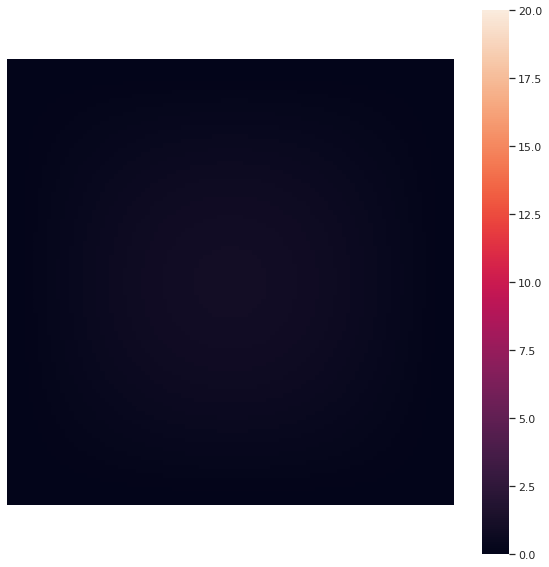

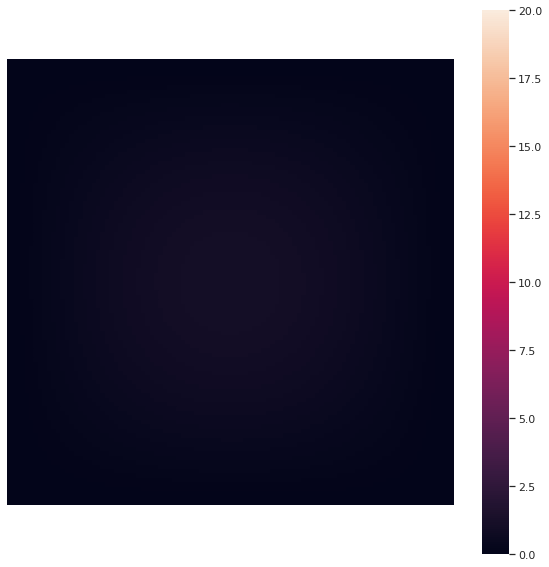

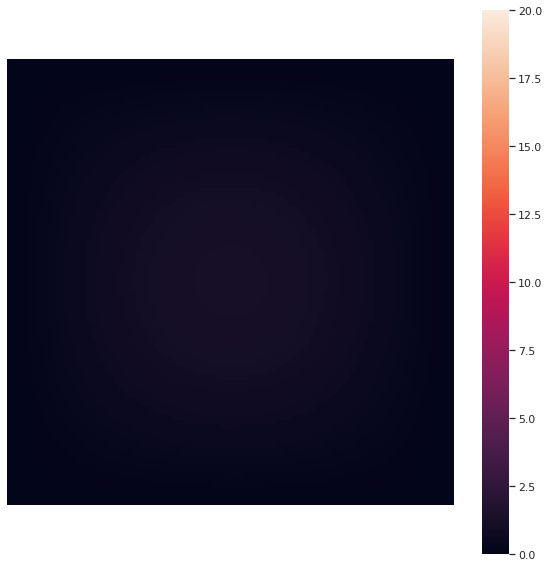

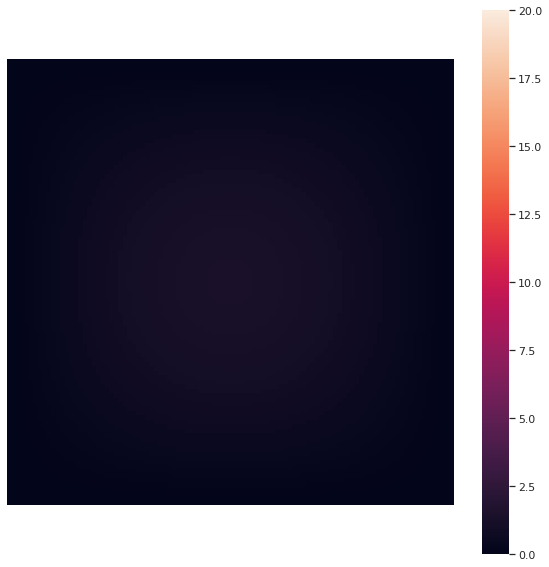

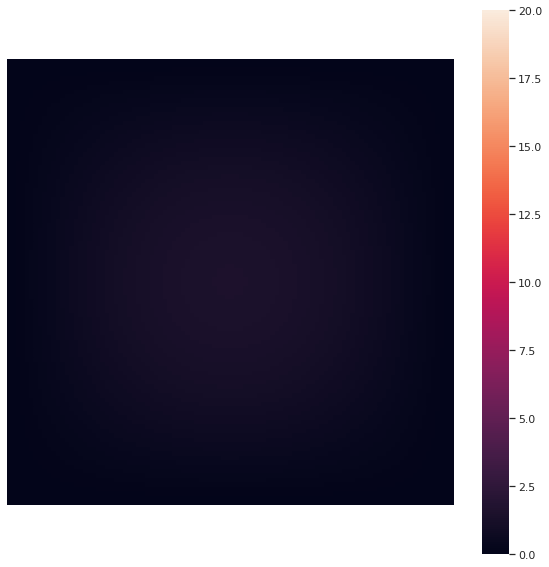

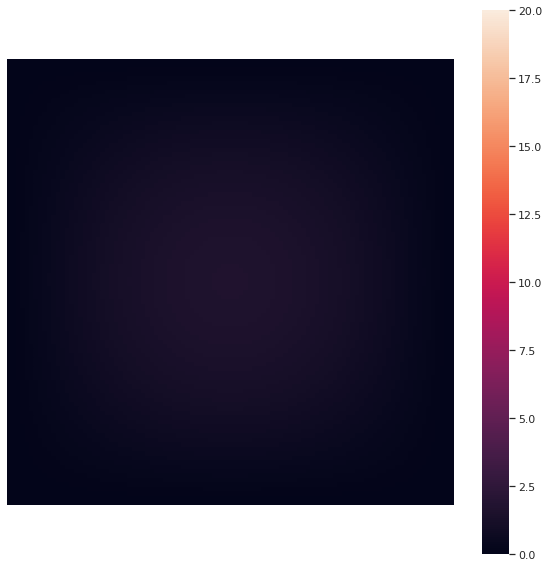

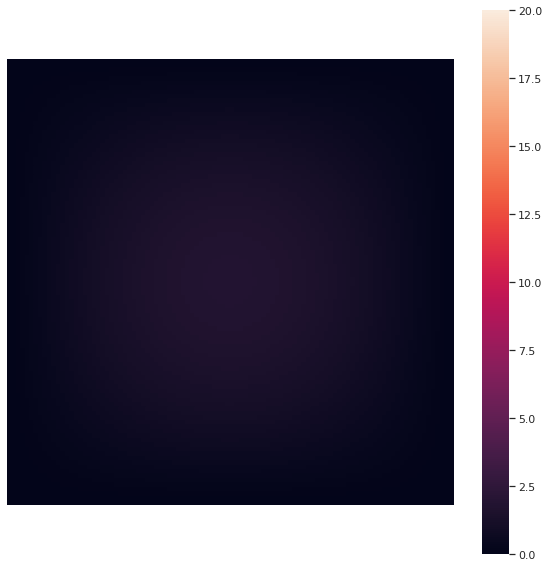

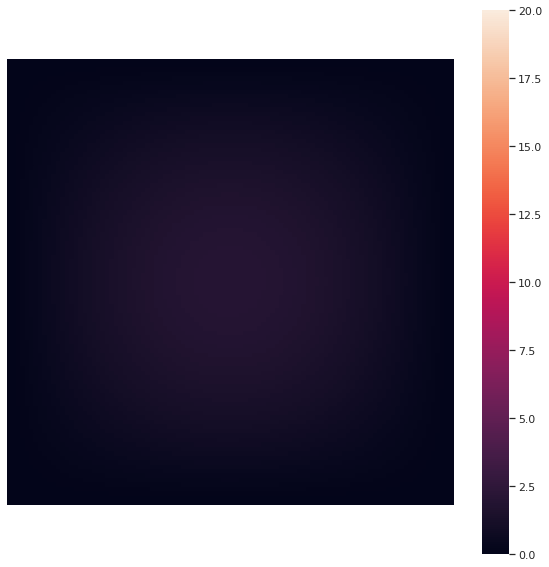

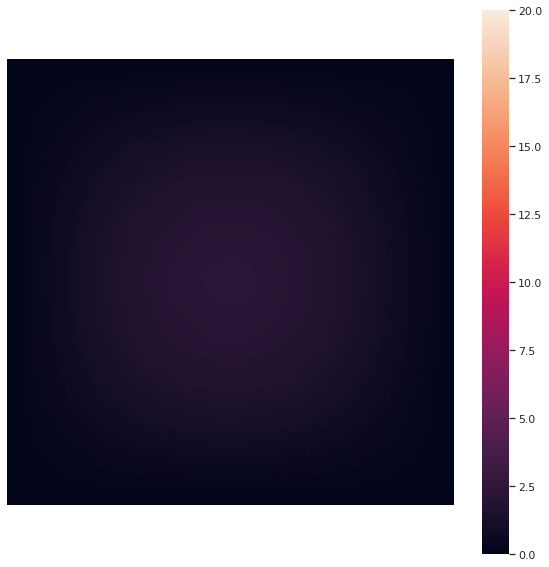

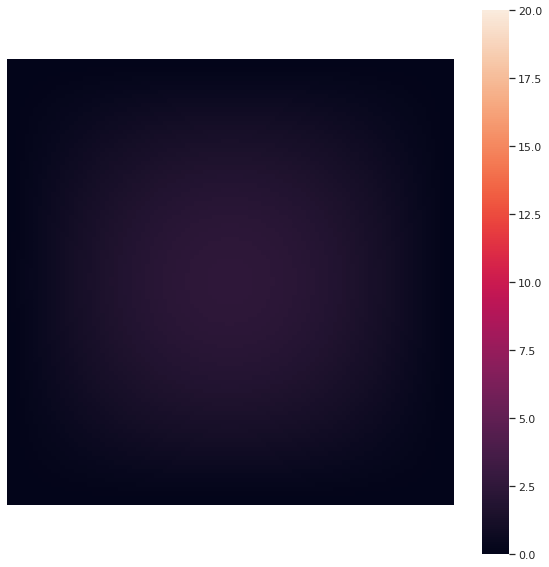

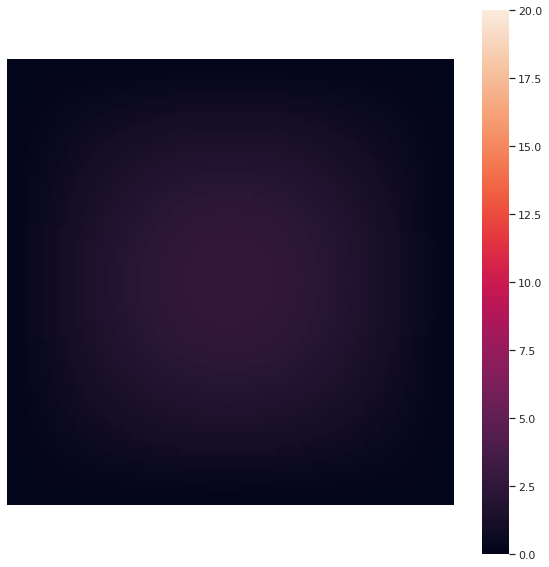

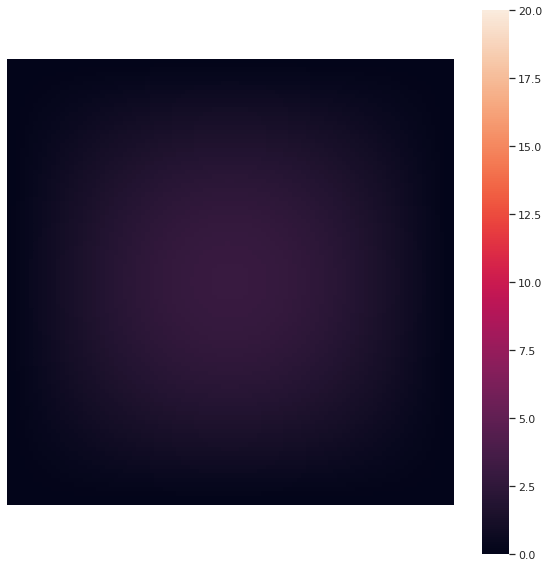

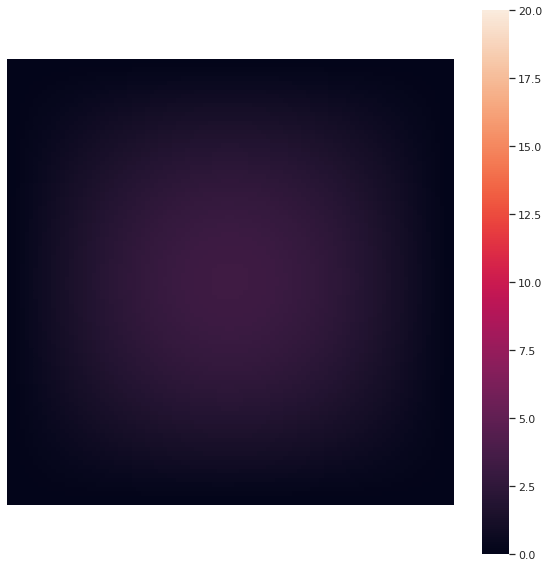

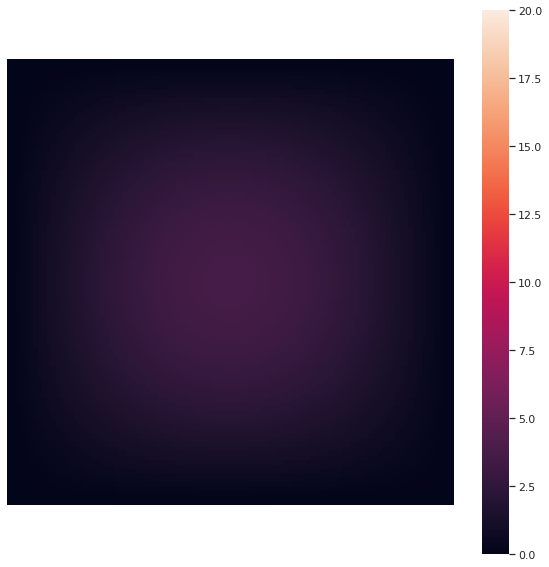

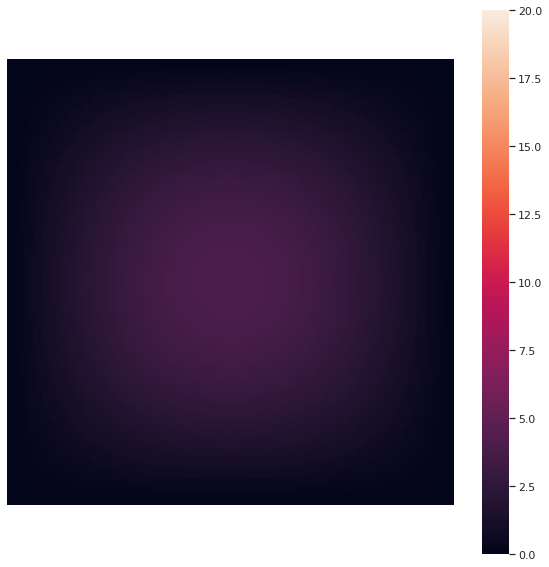

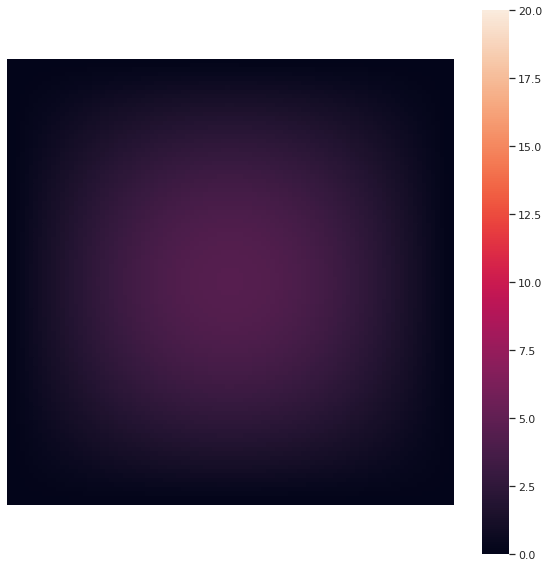

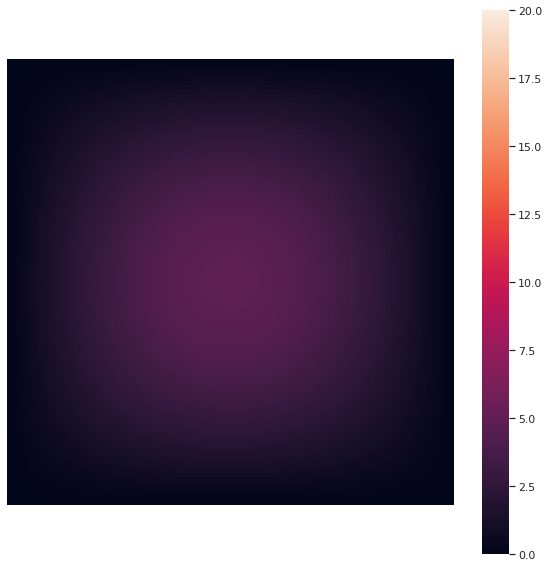

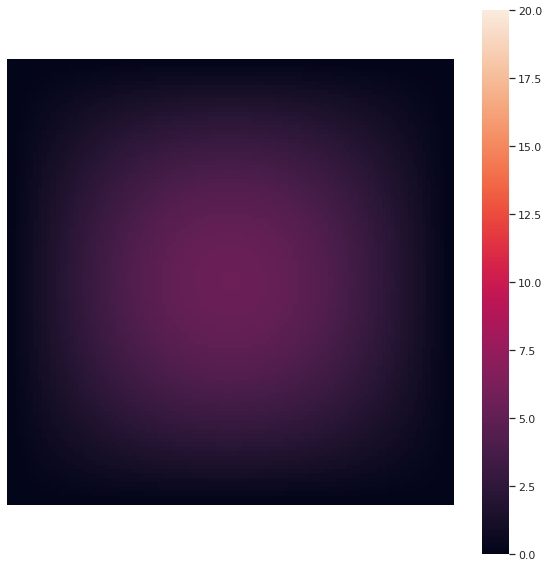

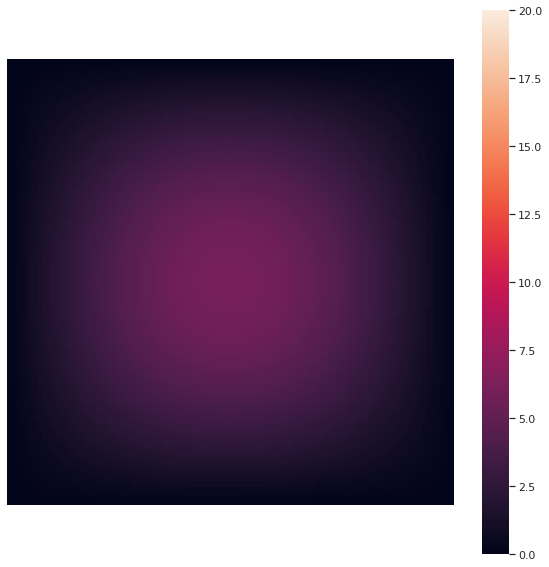

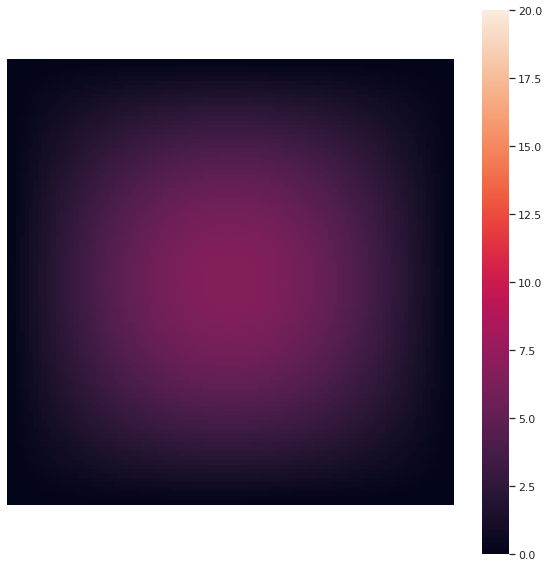

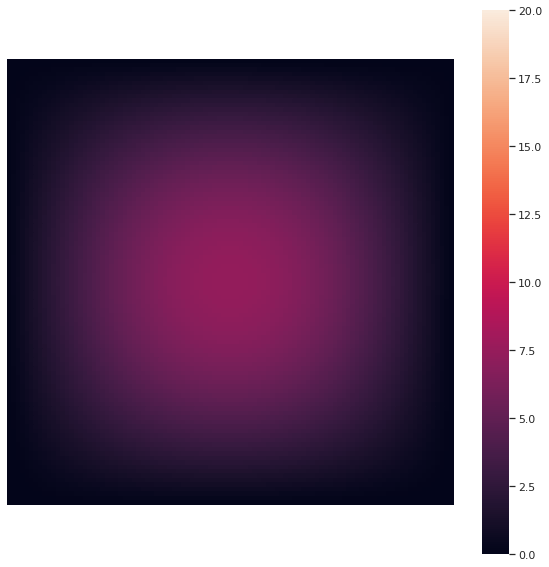

In [14]:
# CREATE IMAGES
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

u_xyt = np.zeros(shape=(n,n), dtype=float)

for k in range(21):
    for i in range(n):
        for j in range(n):
            u1 = u(model1, x[i], y[j], k*0.1)
            u_xyt[i,j] = u1
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(u_xyt, square = True, xticklabels = False, yticklabels = False, vmax = 20, vmin = 0)
    plt.savefig("/content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/4. Heat (multiple steps) (continuous)/images/" + str(k) + ".png")

In [15]:
# CREATE GIF
png_dir = '/content/drive/My Drive/Colab Notebooks/Keras/Solving PDEs/4. Heat (multiple steps) (continuous)/images/'
images = []
for file_name in os.listdir(png_dir):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave(png_dir + 'movie.gif', images, fps = 10)